In [1]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline
from scipy import stats
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [3]:
model_vars_data = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\model_vars_data_n.csv',index_col=0)

test_vars_data = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\test_vars_data_n.csv',index_col=0)

price_train = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\ny_train.csv',index_col=0)

price_test = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\ny_test.csv',index_col=0)

In [4]:
# list(model_vars_data.columns) 
model_vars_data = model_vars_data.drop(['MoSold','MSSubClass','LotArea'], axis = 1)
test_vars_data = test_vars_data.drop(['MoSold','MSSubClass','LotArea'], axis = 1) 
#there is a transformed version of LotArea


In [5]:
# Fucntion returns dictionary

def regx3(
model=  None,
x_train = None,
x_test = None,
y_train = None,
y_test =  None,
params = None,
cv_ = 5,
linear_reg = True,
tree_based = False):
######################################
#########################################

    features = list(x_train.columns)

    ss = StandardScaler()
    x_train = pd.DataFrame(ss.fit_transform(x_train), columns = features)
    x_test = pd.DataFrame(ss.fit_transform(x_test), columns = features)

    #     print('train ',x_train.head())
    #     print(' ')
    #     print('test ', x_test.head())


    gs = GridSearchCV(model, params, cv=cv_, return_train_score=True, refit=True)
    gs.fit(x_train,y_train)
    gs.best_params_

    reg_dict = {}
    model= gs.best_estimator_
    reg_dict['mod'] = model
    ###################################    

    print('best params: ',gs.best_params_)
    reg_dict['best params'] = gs.best_params_

    print('score: ',gs.score(x_train,y_train))
    reg_dict['score'] = gs.score(x_train,y_train)

    print('  ')
    print('test score: ',gs.score(x_test,y_test))
    reg_dict['test score'] = gs.score(x_test,y_test)

    if linear_reg:
        adj_r2 = 1-(1-gs.score(x_train,y_train))*(x_train.shape[0] - 1) / (x_train.shape[0] - x_train.shape[1] - 1)
        print('adj_r2: ', adj_r2)
        reg_dict['adj_r2'] = adj_r2

        adj_r2_test = 1-(1-gs.score(x_test,y_test))*(x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1)
        print('  ')
        print('adj_r2_test: ',adj_r2_test)
        reg_dict['adj_r2_test'] = adj_r2_test

        print(' ')

    train_pred = gs.best_estimator_.predict(x_train)
    print('train RMSE: ' + str(mean_squared_error(train_pred,y_train)**0.5))
    print('  ')
    reg_dict['train RMSE'] = mean_squared_error(train_pred,y_train)**0.5

    test_pred = gs.best_estimator_.predict(x_test)
    print('test RMSE: ' + str(mean_squared_error(test_pred,y_test)**0.5))
    ###
    reg_dict['test RMSE'] = mean_squared_error(test_pred,y_test)**0.5

    if linear_reg:

        coefs = pd.Series(gs.best_estimator_.coef_, name = 'coef' )

        varnames = pd.Series(features, name = 'features')

        pd.set_option('display.max_rows', None) # or 1000.

        abs_coefs = pd.Series(np.abs(coefs),name = 'abs_val')

        coefs_ = pd.concat([varnames,coefs, abs_coefs], axis=1)

        #return:
        model_importances = coefs_.sort_values(by=['abs_val'], ascending=False)
        model_importances.index=(range(model_importances.shape[0]))
        model_importances
        reg_dict['model_importances'] = model_importances

        print(model_importances)
        print(' ')

    elif tree_based:
        pd.set_option('display.max_rows', None) # or 1000.

        #return
        varnames = pd.Series(features, name = 'features')

        importances_ = pd.Series(model.feature_importances_, name = 'importances')

        df = pd.concat([varnames,importances_], axis=1)

        model_importances = df.sort_values(by=['importances'], ascending=False)

        model_importances.index=(range(model_importances.shape[0]))

        reg_dict['model_importances'] = model_importances



    #         model_importances = pd.Series(model.feature_importances_, index = features).sort_values(ascending=False)

        print(model_importances)


    if linear_reg:
        residuals = y_train - train_pred
        print('skewness: ',stats.skew(residuals))
        print(' ')
        sns.set_theme(style='darkgrid')
        sns.histplot(residuals, bins=20);

    print('model_importances.shape: ',model_importances.shape)
    
    return reg_dict


In [6]:
def to_keep(mod, amt):
    mod = mod['model_importances']
    keeps1 = mod.loc[mod['abs_val'] > amt,['features']]
    list_keeps1 = list(keeps1.features)
    return list_keeps1


remove due to mulicollinearity - see Correlations Analysis notebook

In [7]:
remove = ['log_first_FlrSF','BsmtFinSF1', 'BsmtUnfSF','yeo_GarageArea','GarageCars',
          'yeo_LotFrontage', 'BsmtFinSF2' ] #remove due to mulicollinearity #drop GarageYrBlt
#see Correlations Analysis notebook

In [8]:
keeps_set = set(model_vars_data.columns) - set(remove)
keeps_set
keeps = list(keeps_set)

best params:  {'alpha': 0.001, 'tol': 0.02}
score:  0.9452412273148416
  
test score:  0.9258763584989563
adj_r2:  0.9383228732169062
  
adj_r2_test:  0.899591379243267
 
train RMSE: 0.08832901542732452
  
test RMSE: 0.10146907642713004
                                              features      coef   abs_val
0                                         bc_GrLivArea  0.158234  0.158234
1                                           house_age_ -0.068357  0.068357
2                                          OverallQual  0.065812  0.065812
3                                          OverallCond  0.046934  0.046934
4                                           bc_LotArea  0.037804  0.037804
5                                      yeo_TotalBsmtSF  0.034306  0.034306
6                                      log_OpenPorchSF  0.027678  0.027678
7                                        has_openporch -0.024300  0.024300
8         Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.022361  0.022361
9            

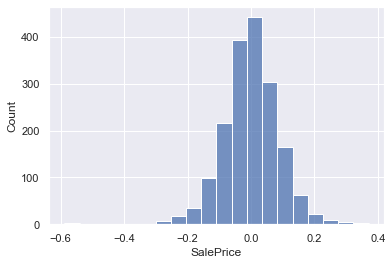

In [9]:
lasso1 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [10]:
keeps = to_keep(lasso1, 0.0002)

best params:  {'alpha': 0.001, 'tol': 0.02}
score:  0.9451033273955944
  
test score:  0.9253331857178297
adj_r2:  0.9404255829253468
  
adj_r2_test:  0.90858101584683
 
train RMSE: 0.08844016570069387
  
test RMSE: 0.1018401769117426
                                              features      coef   abs_val
0                                         bc_GrLivArea  0.132527  0.132527
1                                          OverallQual  0.069599  0.069599
2                                           house_age_ -0.063325  0.063325
3                                      yeo_TotalBsmtSF  0.047000  0.047000
4                                          OverallCond  0.045726  0.045726
5                                           bc_LotArea  0.041862  0.041862
6                                             2ndFlrSF  0.028131  0.028131
7                                          MSZoning_RM -0.022636  0.022636
8                                      Condition1_Norm  0.022013  0.022013
9         Neigh

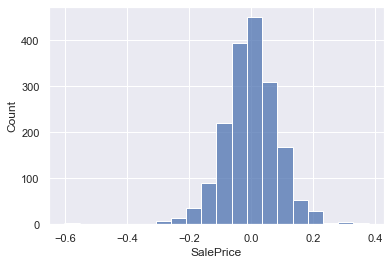

In [11]:
lasso2 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [12]:
keeps = to_keep(lasso2, 0.0002)

best params:  {'alpha': 0.001, 'tol': 0.02}
score:  0.9451539734281995
  
test score:  0.9251044276355093
adj_r2:  0.941019019675802
  
adj_r2_test:  0.9104534940743804
 
train RMSE: 0.08839936015765279
  
test RMSE: 0.10199606241053542
                                              features      coef   abs_val
0                                         bc_GrLivArea  0.142292  0.142292
1                                           house_age_ -0.077582  0.077582
2                                          OverallQual  0.063318  0.063318
3                                          OverallCond  0.047714  0.047714
4                                      yeo_TotalBsmtSF  0.044157  0.044157
5                                           bc_LotArea  0.041382  0.041382
6                                             2ndFlrSF  0.030467  0.030467
7                                          MSZoning_RM -0.026430  0.026430
8         Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.022425  0.022425
9            

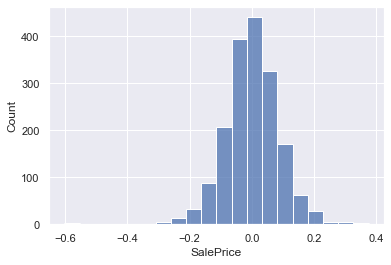

In [13]:
lasso3 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [14]:
keeps = to_keep(lasso3, 0.0005)

best params:  {'alpha': 0.001, 'tol': 0.02}
score:  0.9448012040914859
  
test score:  0.9251156936646697
adj_r2:  0.9411366907267461
  
adj_r2_test:  0.9123865083611143
 
train RMSE: 0.08868319657614915
  
test RMSE: 0.10198839083668397
                                              features      coef   abs_val
0                                         bc_GrLivArea  0.142845  0.142845
1                                           house_age_ -0.072768  0.072768
2                                          OverallQual  0.071246  0.071246
3                                          OverallCond  0.045872  0.045872
4                                      yeo_TotalBsmtSF  0.042891  0.042891
5                                           bc_LotArea  0.042646  0.042646
6                                             2ndFlrSF  0.029921  0.029921
7                                      Condition1_Norm  0.022244  0.022244
8                                          MSZoning_RM -0.021238  0.021238
9         Ne

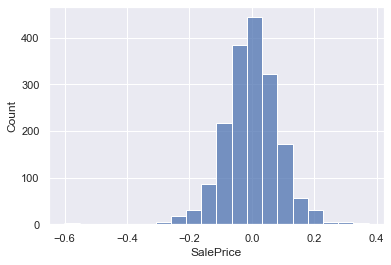

In [15]:
lasso4 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [16]:
features4 = to_keep(lasso4,0)
dummies=[]
for f in features4:
    if model_vars_data[f].max() == 1:
        dummies.append(f)


dummy_drops = []
for feature in dummies:
    if round(model_vars_data[feature].mean(),2) < 0.05:
        dummy_drops.append(feature)
dummy_drops

['SaleCondition_Partial',
 'Exterior1st_BrkFace',
 'Condition1_PosN',
 'SaleCondition_Family',
 'LandContour_HLS',
 'BldgType_Twnhs',
 'Condition1_PosA',
 'MSZoning_RH',
 'MSSubClass_160',
 'Exterior1st_PreCast',
 'Neighborhood_SawyerW',
 'MSSubClass_85',
 'RoofStyle_Mansard',
 'Exterior2nd_Brk Cmn',
 'Exterior2nd_CBlock',
 'Condition2_Feedr',
 'Condition2_PosA',
 'RoofMatl_WdShngl',
 'HouseStyle_1.5Unf',
 'Heating_Grav',
 'HouseStyle_SFoyer',
 'Exterior1st_CBlock',
 'Foundation_Wood',
 'Condition1_RRAn',
 'MSSubClass_150',
 'Heating_Wall',
 'MSSubClass_40',
 'LotConfig_FR2',
 'Condition2_RRNn',
 'GarageType_Basment',
 'Exterior2nd_BrkFace',
 'Heating_OthW',
 'has_pool',
 'Condition1_RRNn',
 'RoofMatl_Membran',
 'RoofStyle_Gambrel',
 'Foundation_Stone',
 'BldgType_Duplex',
 'LotConfig_FR3',
 'PavedDrive_P',
 'Condition2_RRAn',
 'RoofMatl_Tar&Grv',
 'Exterior1st_AsphShn',
 'MSSubClass_75',
 'Exterior1st_WdShing',
 'Fence_MnWw',
 'MoSold_11',
 'MSSubClass_180']

In [17]:
keep_set = set(features4) - set(dummy_drops)
keeps = list(keep_set)
# keeps

best params:  {'alpha': 0.001, 'tol': 0.02}
score:  0.9354804886552655
  
test score:  0.9235802862052476
adj_r2:  0.9331561367067626
  
adj_r2_test:  0.9168309667532893
 
train RMSE: 0.0958786855506625
  
test RMSE: 0.10302865668098982
                                             features      coef   abs_val
0                                        bc_GrLivArea  0.137791  0.137791
1                                         OverallQual  0.065903  0.065903
2                                          house_age_ -0.056878  0.056878
3                                     yeo_TotalBsmtSF  0.049589  0.049589
4                                         OverallCond  0.049199  0.049199
5                                          bc_LotArea  0.045680  0.045680
6                                            2ndFlrSF  0.028387  0.028387
7        Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027287  0.027287
8                                          Fireplaces  0.023696  0.023696
9                      

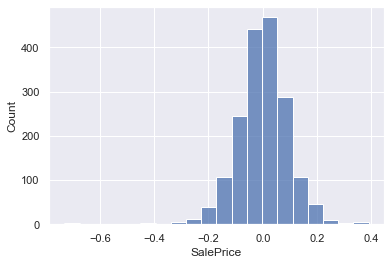

In [19]:
lasso5 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [ ]:
combine = pd.concat([price_train, model_vars_data], axis=1)
combine["log_price"] = np.log(combine.SalePrice)
combine.head(3)

In [ ]:
features5 = to_keep(lasso5,0)
set5 = set(features5)
set5.add('log_price')
set5

list5 = list(set5)
type(list5)
combine[list5]

In [22]:
pd.set_option('display.max_rows', None)


print("look at correlations with target")
df4a = combine[list5]
type(df4a)
corr = df4a.corr()
corr.sort_values(["log_price"], ascending = False, inplace = True)


# # type(corr.SalePrice)
# # # type(corr)
print(corr.log_price)
# type(combine)

look at correlations with target
log_price                                              1.000000
OverallQual                                            0.812202
bc_GrLivArea                                           0.731467
ExterQual                                              0.681508
KitchenQual                                            0.658549
yeo_TotalBsmtSF                                        0.641523
GarageYrBlt                                            0.591040
Neighborhood_NoRidge_NridgHt_Veenker_StoneBr           0.516683
Fireplaces                                             0.505697
TotRmsAbvGrd                                           0.496065
HeatingQC                                              0.479445
bc_LotArea                                             0.406382
BsmtExposure                                           0.369880
BsmtFinType1                                           0.367016
CentralAir_Y                                           0.328941
GarageC

In [25]:
drops =[ 'OverallCond',
'BldgType_TwnhsE',
'3SsnPorch',
'MSSubClass_70',
'has_finsished_basement'
'BsmtHalfBath',
'MoSold_7',
'LowQualFinSF',
'HouseStyle_1Story',
'Exterior2nd_Plywood',
'MoSold_3',
'MoSold_6',
'MoSold_9',
'Exterior1st_Plywood']

keeps_set = set(to_keep(lasso5,0)) - set(drops)
keeps_set
keeps = list(keeps_set)

best params:  {'alpha': 1e-08, 'tol': 0.02}
score:  0.924871922645889
  
test score:  0.9134688378193743
adj_r2:  0.9230153092400115
  
adj_r2_test:  0.9083081721137336
 
train RMSE: 0.10346123877360823
  
test RMSE: 0.10963307673984463
                                             features      coef   abs_val
0                                        bc_GrLivArea  0.127821  0.127821
1                                         OverallQual  0.074495  0.074495
2                                          bc_LotArea  0.048804  0.048804
3                                     yeo_TotalBsmtSF  0.045469  0.045469
4                              years_since_remodeled_ -0.028874  0.028874
5                                          Functional  0.027710  0.027710
6        Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.026993  0.026993
7                                          house_age_ -0.023751  0.023751
8                                          Fireplaces  0.023483  0.023483
9                      

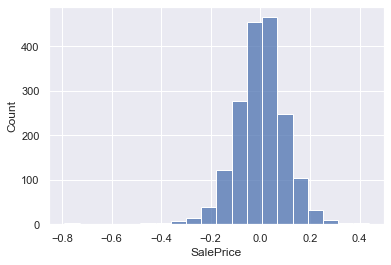

In [26]:
lasso6 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [29]:

keeps = to_keep(lasso6,0.004)

best params:  {'alpha': 1e-10, 'tol': 0.02}
score:  0.9246963023383333
  
test score:  0.9132780633769069
adj_r2:  0.9231005195127424
  
adj_r2_test:  0.9088644297385926
 
train RMSE: 0.10358209431167288
  
test RMSE: 0.10975386371053887
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.126447  0.126447
1                                    OverallQual  0.074355  0.074355
2                                     bc_LotArea  0.047931  0.047931
3                                yeo_TotalBsmtSF  0.045751  0.045751
4                         years_since_remodeled_ -0.028271  0.028271
5                                     Functional  0.027597  0.027597
6   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.026911  0.026911
7                                     Fireplaces  0.023361  0.023361
8                                     house_age_ -0.022433  0.022433
9                                   BsmtFullBath  0.020872  0.020872
10 

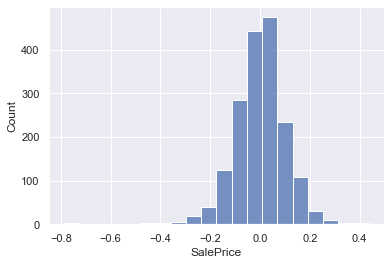

In [30]:
lasso7 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)
 
 

In [31]:
model_vars_data.GarageYrBlt.corr(model_vars_data['house_age_'])

-0.8495290774467831

In [33]:
keeps_set = set(to_keep(lasso7,0.0)) - set(['GarageYrBlt'])
keeps = list(keeps_set)

best params:  {'alpha': 1e-08, 'tol': 0.02}
score:  0.9245515795163851
  
test score:  0.9134319640115615
adj_r2:  0.9229968324428819
  
adj_r2_test:  0.9091511270670782
 
train RMSE: 0.1036815814410162
  
test RMSE: 0.10965643340304596
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.127204  0.127204
1                                    OverallQual  0.074502  0.074502
2                                     bc_LotArea  0.048147  0.048147
3                                yeo_TotalBsmtSF  0.045330  0.045330
4                                     house_age_ -0.029357  0.029357
5                         years_since_remodeled_ -0.029056  0.029056
6                                     Functional  0.027794  0.027794
7   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.026938  0.026938
8                                     Fireplaces  0.022650  0.022650
9                                       2ndFlrSF  0.020790  0.020790
10  

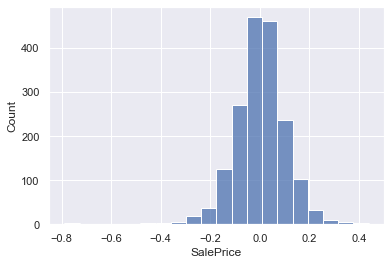

In [34]:
lasso8 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)
 
 

In [35]:
#copy lasso 5 and drop GarageYrBlt since correlated with house age
keeps_set = set(to_keep(lasso5,0)) - set(['GarageYrBlt'])
keeps = list(keeps_set)

best params:  {'alpha': 1e-08, 'tol': 0.02}
score:  0.935703649049997
  
test score:  0.9225275819130626
adj_r2:  0.9336955501770646
  
adj_r2_test:  0.9166353134951829
 
train RMSE: 0.09571272909531003
  
test RMSE: 0.10373585474337221
                                             features      coef   abs_val
0                                        bc_GrLivArea  0.134734  0.134734
1                                          house_age_ -0.075093  0.075093
2                                         OverallQual  0.064894  0.064894
3                                     yeo_TotalBsmtSF  0.051207  0.051207
4                                         OverallCond  0.050965  0.050965
5                                          bc_LotArea  0.046839  0.046839
6                                            2ndFlrSF  0.032346  0.032346
7        Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027123  0.027123
8                                          Fireplaces  0.022392  0.022392
9                      

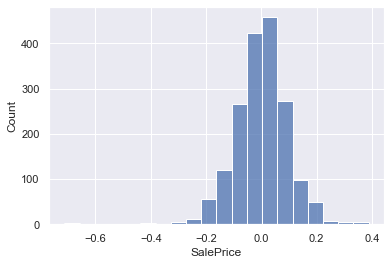

In [36]:
lasso9 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)
 

In [37]:
keeps= to_keep(lasso9,.002)

best params:  {'alpha': 1e-08, 'tol': 0.02}
score:  0.9356491223190734
  
test score:  0.9225734833024011
adj_r2:  0.9337924899566693
  
adj_r2_test:  0.9171514583235776
 
train RMSE: 0.09575330524108197
  
test RMSE: 0.10370511912492344
                                             features      coef   abs_val
0                                        bc_GrLivArea  0.134264  0.134264
1                                          house_age_ -0.075282  0.075282
2                                         OverallQual  0.064940  0.064940
3                                     yeo_TotalBsmtSF  0.051147  0.051147
4                                         OverallCond  0.051055  0.051055
5                                          bc_LotArea  0.047439  0.047439
6                                            2ndFlrSF  0.032499  0.032499
7        Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027150  0.027150
8                                          Fireplaces  0.022332  0.022332
9                     

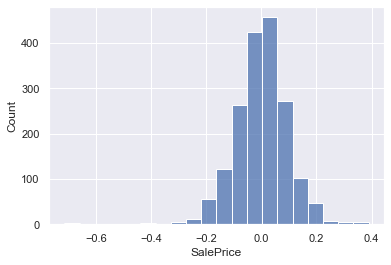

In [38]:
lasso10 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [39]:
keeps = to_keep(lasso10,0.003)

best params:  {'alpha': 1e-08, 'tol': 0.02}
score:  0.9354710567232569
  
test score:  0.9229524207725474
adj_r2:  0.9338002843139052
  
adj_r2_test:  0.9181302496108849
 
train RMSE: 0.09588569341678453
  
test RMSE: 0.10345103333156846
                                             features      coef   abs_val
0                                        bc_GrLivArea  0.133813  0.133813
1                                          house_age_ -0.074014  0.074014
2                                         OverallQual  0.064498  0.064498
3                                         OverallCond  0.052021  0.052021
4                                     yeo_TotalBsmtSF  0.051282  0.051282
5                                          bc_LotArea  0.047282  0.047282
6                                            2ndFlrSF  0.032617  0.032617
7        Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.026658  0.026658
8                                          Fireplaces  0.022224  0.022224
9                     

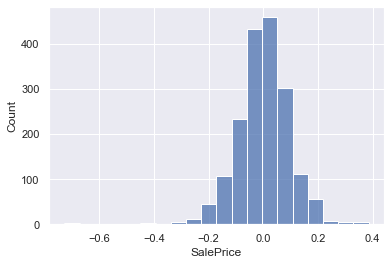

In [40]:
lasso11 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [41]:
keeps = to_keep(lasso11,0.004)

best params:  {'alpha': 1e-08, 'tol': 0.02}
score:  0.9351024368198345
  
test score:  0.9227486559258107
adj_r2:  0.9335749970434931
  
adj_r2_test:  0.918367874311645
 
train RMSE: 0.09615917566780474
  
test RMSE: 0.10358773954219365
                                             features      coef   abs_val
0                                        bc_GrLivArea  0.132351  0.132351
1                                          house_age_ -0.074751  0.074751
2                                         OverallQual  0.064322  0.064322
3                                         OverallCond  0.052267  0.052267
4                                     yeo_TotalBsmtSF  0.051527  0.051527
5                                          bc_LotArea  0.047463  0.047463
6                                            2ndFlrSF  0.034698  0.034698
7        Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.026864  0.026864
8                                          Fireplaces  0.022473  0.022473
9                      

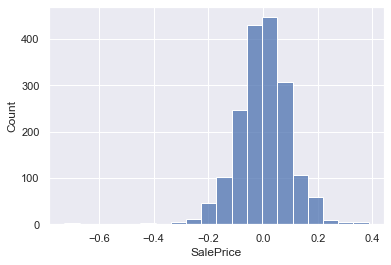

In [42]:
lasso12 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)